# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.utils import shuffle
from sklearn.svm import SVR

# Preprocessing

In [8]:
TARGET = "TOTAL_CONS"
# COL_TO_DROP = ['humidity', 'hour', 'weekday', 'dayofyear']
START_TRAIN_DATE = 2017
VAL_DATE = 2017
TEST_DATE = 2018
DAYS_FOR_INFERENCE = 1
DAYS_FORWARD_TO_SKIP = 0
DAYS_BACK_TO_SKIP = 10
START_STEP_FORWARD = 24 * DAYS_FORWARD_TO_SKIP + 1
LAST_STEP_FORWARD = 24 * (DAYS_FORWARD_TO_SKIP + DAYS_FOR_INFERENCE)
STEPS_BACKWARD_START = 24 * DAYS_BACK_TO_SKIP

In [9]:
df = pd.read_csv("/content/FINAL_DATASET_2.csv")
df.set_index(pd.to_datetime(df["Timestamp"]), inplace=True)
df.drop("Timestamp", axis=1, inplace=True)
# df.drop(COL_TO_DROP, axis=1, inplace=True)
df

,TOTAL_CONS,Weekend,Holiday,temp,humidity,hour,weekday,dayofyear
Timestamp,,,,,,,,
2010-10-01 00:00:00,4390.054,0,0,16.12,79.0,0,4,274
2010-10-01 01:00:00,4046.071,0,0,15.19,77.0,1,4,274
2010-10-01 02:00:00,3885.451,0,0,14.65,82.0,2,4,274
2010-10-01 03:00:00,3808.100,0,0,14.03,71.0,3,4,274
2010-10-01 04:00:00,3782.623,0,0,13.29,77.0,4,4,274
...,...,...,...,...,...,...,...,...
2020-11-22 19:00:00,4281.942,1,0,10.74,54.0,19,6,327
2020-11-22 20:00:00,4091.488,1,0,10.15,51.0,20,6,327
2020-11-22 21:00:00,3738.827,1,0,9.81,51.0,21,6,327


In [10]:
TARGET_POS = np.where(df.columns == TARGET)[0][0]

train_val_df = df[(df.index.year >= START_TRAIN_DATE) & (df.index.year <= VAL_DATE)]
test_df = df[(df.index.year == TEST_DATE)]

scaler = MinMaxScaler()
train_val_scaled = scaler.fit_transform(train_val_df)
train_val_df_scaled = pd.DataFrame(train_val_scaled,
                                   columns=train_val_df.columns,
                                   index=train_val_df.index)
test_scaled = scaler.transform(test_df)
test_df_scaled = pd.DataFrame(test_scaled,
                              columns=test_df.columns,
                              index=test_df.index)

scaled_df = pd.concat([train_val_df_scaled, test_df_scaled], axis=0)
scaled_df

,TOTAL_CONS,Weekend,Holiday,temp,humidity,hour,weekday,dayofyear
Timestamp,,,,,,,,
2017-01-01 00:00:00,0.466948,1.0,1.0,0.114109,0.588235,0.000000,1.0,0.0
2017-01-01 01:00:00,0.404406,1.0,1.0,0.104086,0.705882,0.043478,1.0,0.0
2017-01-01 02:00:00,0.385644,1.0,1.0,0.113081,0.670588,0.086957,1.0,0.0
2017-01-01 03:00:00,0.336320,1.0,1.0,0.103315,0.776471,0.130435,1.0,0.0
2017-01-01 04:00:00,0.292540,1.0,1.0,0.113338,0.764706,0.173913,1.0,0.0
...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,0.722865,0.0,1.0,0.214084,0.847059,0.826087,0.0,1.0
2018-12-31 20:00:00,0.664355,0.0,1.0,0.209715,0.635294,0.869565,0.0,1.0
2018-12-31 21:00:00,0.537252,0.0,1.0,0.205603,0.494118,0.913043,0.0,1.0


# Training + Inference

In [11]:
mape_list = list()
for step_forward in np.arange(START_STEP_FORWARD, LAST_STEP_FORWARD + 1, step=1):
# for step_forward in np.arange(7):
  scaled_df_copy = scaled_df.copy()  # pd.DataFrame()

  # *** shift Weather + Time data ***
  for col in scaled_df.drop(TARGET, axis=1).columns:
    scaled_df_copy[col + f"_(t+{step_forward})"] = scaled_df[col].shift(-step_forward)
    scaled_df_copy.drop(col, axis=1, inplace=True)

  # ---------- REFRAMING -----------------
  # *** shift Target ***
  scaled_df_copy[TARGET + f"_(t+{step_forward})"] = scaled_df[TARGET].shift(-step_forward)

  # *** shift Backsteps *** 
  # if (step_forward == 0) or (step_forward == 1):
  #   scaled_df_copy[TARGET + "_(t-1)"] = scaled_df[TARGET].shift(1)
  #   # scaled_df_copy[TARGET + "_(t-24)"] = scaled_df[TARGET].shift(24)
  # else:
  for day_back in np.arange(DAYS_BACK_TO_SKIP + 1, DAYS_BACK_TO_SKIP + 11, step=1):
    step_back = 24 * day_back - step_forward
    scaled_df_copy[TARGET + f"_(t-{step_back})"] = scaled_df[TARGET].shift(step_back)
      
  refr_df = scaled_df_copy.drop(TARGET, axis=1).copy()
  refr_df.dropna(inplace=True)

  # print()
  # print(np.abs(refr_df.corr())[TARGET + f"_(t+{step_forward})"])
  # print()
  # print(refr_df.columns)

  # split to train-val and test sets
  train_val_df_refr = refr_df[(refr_df.index.year >= START_TRAIN_DATE) & (refr_df.index.year <= VAL_DATE)]
  test_df_refr = refr_df[(refr_df.index.year == TEST_DATE)]

  # shuffle train-val and test sets
  train_val_df_refr = shuffle(train_val_df_refr)

  # split to features and targets
  X_train_val_df = train_val_df_refr.drop(TARGET + f"_(t+{step_forward})", axis=1)
  y_train_val_df = train_val_df_refr[TARGET + f"_(t+{step_forward})"]

  X_test_df = test_df_refr.drop(TARGET + f"_(t+{step_forward})", axis=1)
  y_test_df = test_df_refr[TARGET + f"_(t+{step_forward})"]

  # for max_depth in np.arange(3, 11):
  #   for eta in np.arange(0.01, 0.2, 0.01):
  #     print(f"\nmax_depth = {max_depth}, eta = {eta}")
  # XGBoost
  xgb = XGBRegressor(max_depth=6, eta=0.06)
  xgb.fit(X_train_val_df, y_train_val_df)
  y_step_preds_scaled = xgb.predict(X_test_df)

  # # SVR
  # svr = SVR(C=10, gamma=0.1)
  # svr.fit(X_train_val_df, y_train_val_df)
  # y_step_preds_scaled = svr.predict(X_test_df)

  y_step_preds = scaler.data_min_[TARGET_POS] + y_step_preds_scaled * (scaler.data_max_[TARGET_POS] - scaler.data_min_[TARGET_POS])
  y_step_test = scaler.data_min_[TARGET_POS] + y_test_df.to_numpy() * (scaler.data_max_[TARGET_POS] - scaler.data_min_[TARGET_POS])

  step_results = pd.DataFrame(
      {
        "real": y_step_test,
        "predictions": y_step_preds
      },
      index=y_test_df.index + pd.to_timedelta(step_forward, 'h')
  )

  step_results['abs_error'] = np.abs(step_results["real"] - step_results["predictions"])
  step_results['ape'] = np.where(step_results["real"] == 0, np.NaN, 100 * step_results['abs_error'] / step_results["real"])
  step_mape = step_results['ape'].mean()
  mape_list.append(step_mape)

  print(f"step {step_forward} -> MAPE = {step_mape}%")
MAPE = np.mean(np.array(mape_list))
print(f"\nOverall MAPE = {MAPE}%")

step 1 -> MAPE = 6.21470549872128%
step 2 -> MAPE = 6.266665302101795%
step 3 -> MAPE = 6.26250115451419%
step 4 -> MAPE = 6.262687765345635%
step 5 -> MAPE = 6.234759354685433%
step 6 -> MAPE = 6.221978726933899%
step 7 -> MAPE = 6.280843056086276%
step 8 -> MAPE = 6.222521707707756%
step 9 -> MAPE = 6.2679750065051225%
step 10 -> MAPE = 6.20653269167011%
step 11 -> MAPE = 6.2170143049913715%
step 12 -> MAPE = 6.189175248729316%
step 13 -> MAPE = 6.215784539535431%
step 14 -> MAPE = 6.243300028341719%
step 15 -> MAPE = 6.225586807934141%
step 16 -> MAPE = 6.227147793309379%
step 17 -> MAPE = 6.299287094162574%
step 18 -> MAPE = 6.201594597691506%
step 19 -> MAPE = 6.24821091957862%
step 20 -> MAPE = 6.182566231853696%
step 21 -> MAPE = 6.194052978517051%
step 22 -> MAPE = 6.224215503123937%
step 23 -> MAPE = 6.234838871387021%
step 24 -> MAPE = 6.227798395934825%

Overall MAPE = 6.23215598247342%


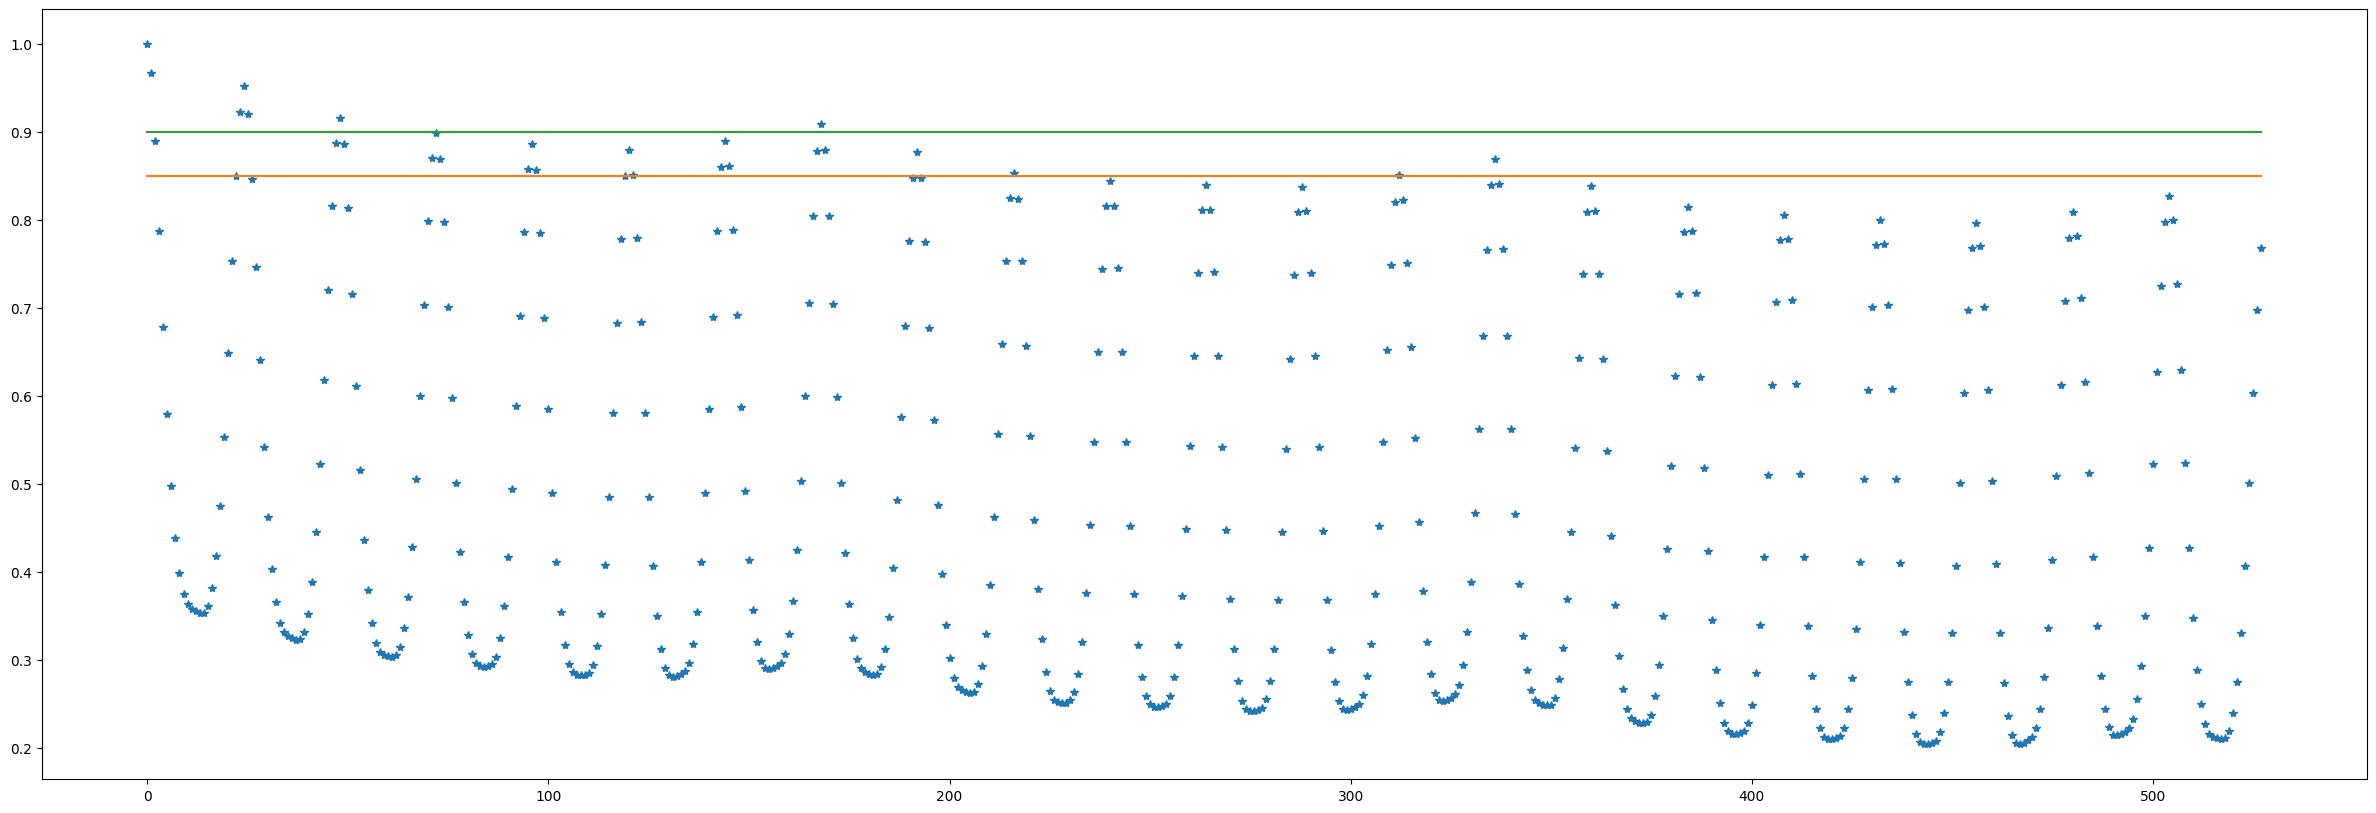

In [ ]:
autocorr_list = []
days = 22
lags = 24 * days
for lag in range(lags):
  autocorr_list.append(df["TOTAL_CONS"].autocorr(lag=lag))

autocorr = np.array(autocorr_list)
plt.figure(figsize=(30, 10))
plt.plot(autocorr, "*")
plt.plot(0.85 * np.ones(lags))
plt.plot(0.9 * np.ones(lags))
plt.show()

In [ ]:
autocorr[24]

0.9523426742804941